### Steps done:

1. Preprocessing data that includes converting a column with dictionary to individual columns
2. EDA on data
3. Getting embeddings for images using pre-trained model (here I have used, densnet121)
4. Label Encoding other columns to make product vectors.
5. Generating cosine similarity for each product with other products.
6. Returning most similar n-products for given product.

In [1]:
# Importing libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from ast import literal_eval
import numpy as np
import seaborn as sns
import urllib.request as request
import matplotlib.pyplot as plt
import matplotlib.image as img
import datetime as dt

In [2]:
# Initial DataFrame
df = pd.read_csv("dataset_with_image_embeddings.csv")
df.head(1)

C:\Users\prath\AppData\Local\Temp\ipykernel_4588\4170024471.py:2: DtypeWarning: Columns (9,12,22,29,30,31,32,34,35,36,38,39,48,51,53,54,55,58,59,61,64,65,66,72,73,74,75,76,77,78,79,80,81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset_with_image_embeddings.csv")


,Unnamed: 0,p_id,name,price,colour,brand,ratingCount,avg_rating,Body Shape ID,Bottom Closure,Bottom Fabric,Bottom Pattern,Bottom Type,Character,Dupatta,Dupatta Border,Dupatta Fabric,Dupatta Pattern,Main Trend,Neck,Occasion,Ornamentation,Pattern Coverage,Print or Pattern Type,Sleeve Length,Sleeve Styling,Slit Detail,Stitch,Technique,Top Design Styling,Top Fabric,Top Hemline,Top Length,Top Pattern,Top Shape,Top Type,Waistband,Weave Type,Colour Family,Design Styling,Fabric,Fabric 2,Hemline,Length,Pattern,Center Front Open,Closure,Fabric Type,Lining,Multipack Set,Surface Styling,Transparency,Type,Distress,Effects,Fade,Features,Fit,Shade,Stretch,Type of Distress,Waist Rise,Knit or Woven,Sport,Sub Trend,Fly Type,Type of Pleat,Trends,Blouse,Blouse Fabric,Border,Saree Fabric,Kurta Fabric,Kurta Pattern,Blouse Closure,Choli Stitch,Lehenga Closure,Lehenga Fabric,Lehenga Lining Fabric,Lehenga Stitch,Pattern Size,Collar,Lining Fabric,Front Styling,Hood,Pocket,image_embeddings
0,0,17048614.0,Khushal K Women Black Ethnic Motifs Printed Ku...,5099.0,Black,Khushal K,4522.0,4.418399,"443,333,324,424",Slip-On,Viscose Rayon,Printed,Palazzos,NaN,With Dupatta,Solid,Viscose Rayon,Printed,Indie Prints,Mandarin Collar,Festive,NaN,Placement,Ethnic Motifs,Three-Quarter Sleeves,Regular Sleeves,NaN,Ready to Wear,Screen,Regular,Viscose Rayon,Flared,Calf Length,Printed,Anarkali,Kurta,Elasticated,Machine Weave,NaN,NaN,NaN,na,NaN,NaN,NaN,na,NaN,NaN,NaN,na,na,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,NaN,na,NaN,NaN,na,NaN,NaN,NaN,na,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.00039085777825675905, 0.0033299396745860577..."


In [3]:
# Dropping rows without images
df = df.dropna(subset=['image_embeddings'])

In [4]:
# Label Encoding all columns except name, p_id and price
le = LabelEncoder()
df.columns.difference(['name', 'p_id', 'price', 'image_embeddings'])
columns_to_encode = df.columns.difference(['name', 'p_id', 'price', 'image_embeddings'])
df[columns_to_encode] = df[columns_to_encode].apply(le.fit_transform)

In [5]:
# Converting string to list 
df['image_embeddings'] = df['image_embeddings'].apply(literal_eval)

In [6]:
# Dividing list into individual columns
split_df = df['image_embeddings'].apply(pd.Series)
df = pd.concat([df.drop(columns=['image_embeddings'], axis=1), split_df], axis=1)
df = df.drop(columns=['Unnamed: 0'])

In [7]:
# Labeling prices in the range of [0, 500, 1K, 4K, 7K, 10K, 15K, 20K, 25K, 30K, 35K, 40K, 45K, 50K]

price_range = [0, 500]+list(range(1000, 13000, 3000))+list(range(15000, 55000, 5000))
df['price'] = pd.cut(df['price'], bins=price_range, include_lowest=True, labels=list(range(len(price_range)-1)))

In [8]:
df.head(1)

,p_id,name,price,colour,brand,ratingCount,avg_rating,Body Shape ID,Bottom Closure,Bottom Fabric,Bottom Pattern,Bottom Type,Character,Dupatta,Dupatta Border,Dupatta Fabric,Dupatta Pattern,Main Trend,Neck,Occasion,Ornamentation,Pattern Coverage,Print or Pattern Type,Sleeve Length,Sleeve Styling,Slit Detail,Stitch,Technique,Top Design Styling,Top Fabric,Top Hemline,Top Length,Top Pattern,Top Shape,Top Type,Waistband,Weave Type,Colour Family,Design Styling,Fabric,Fabric 2,Hemline,Length,Pattern,Center Front Open,Closure,Fabric Type,Lining,Multipack Set,Surface Styling,Transparency,Type,Distress,Effects,Fade,Features,Fit,Shade,Stretch,Type of Distress,Waist Rise,Knit or Woven,Sport,Sub Trend,Fly Type,Type of Pleat,Trends,Blouse,Blouse Fabric,Border,Saree Fabric,Kurta Fabric,Kurta Pattern,Blouse Closure,Choli Stitch,Lehenga Closure,Lehenga Fabric,Lehenga Lining Fabric,Lehenga Stitch,Pattern Size,Collar,Lining Fabric,Front Styling,Hood,Pocket,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,

In [9]:
# Converting column names to str to use in MinMaxScaler
df.columns = df.columns.astype(str)
scaler = MinMaxScaler()
df[df.columns[2::]] = scaler.fit_transform(df[df.columns[2::]])

In [10]:
# Final dataframe
df.head(5)

,p_id,name,price,colour,brand,ratingCount,avg_rating,Body Shape ID,Bottom Closure,Bottom Fabric,Bottom Pattern,Bottom Type,Character,Dupatta,Dupatta Border,Dupatta Fabric,Dupatta Pattern,Main Trend,Neck,Occasion,Ornamentation,Pattern Coverage,Print or Pattern Type,Sleeve Length,Sleeve Styling,Slit Detail,Stitch,Technique,Top Design Styling,Top Fabric,Top Hemline,Top Length,Top Pattern,Top Shape,Top Type,Waistband,Weave Type,Colour Family,Design Styling,Fabric,Fabric 2,Hemline,Length,Pattern,Center Front Open,Closure,Fabric Type,Lining,Multipack Set,Surface Styling,Transparency,Type,Distress,Effects,Fade,Features,Fit,Shade,Stretch,Type of Distress,Waist Rise,Knit or Woven,Sport,Sub Trend,Fly Type,Type of Pleat,Trends,Blouse,Blouse Fabric,Border,Saree Fabric,Kurta Fabric,Kurta Pattern,Blouse Closure,Choli Stitch,Lehenga Closure,Lehenga Fabric,Lehenga Lining Fabric,Lehenga Stitch,Pattern Size,Collar,Lining Fabric,Front Styling,Hood,Pocket,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,

In [11]:
df.shape

(14213, 1109)

In [12]:
# Calculating similarity between products
similarity_matrix = cosine_similarity(df[df.columns[2::]])
similarity_matrix.shape

(14213, 14213)

### Finding similar products

In [15]:
import matplotlib.image as image
import matplotlib.pyplot as plt

image_directory = 'H:/work_projects/College/RecSys_assignment/Myntra Images/images'

# Function to plot images from directory
def plot_image(p_id):
    image_path = image_directory + '/' + str(int(p_id)) + '.jpg'    
    img = image.imread(image_path)
    plt.imshow(img)

# Finding n similar items using for current item and plotting them
def find_n_similar(product_idx, n):
    first_product = similarity_matrix[product_idx]
    top_n_idx = np.argsort(first_product)[-(n+1):][:-1]
    fig, ax = plt.subplots(n+1, figsize=(45, 45))
    image_path = image_directory + '/' + str(int(df.iloc[product_idx]['p_id'])) + '.jpg'
    ax[0].imshow(img.imread(image_path))
    ax[0].set_title('Original Product')
    for idx, i in enumerate(reversed(top_n_idx)):
        image_path = image_directory + '/' + str(int(df.iloc[i]['p_id'])) + '.jpg'   
        image = img.imread(image_path)
        ax[idx+1].imshow(image)
        ax[idx+1].set_title(f'Recommendation: {idx+1}')

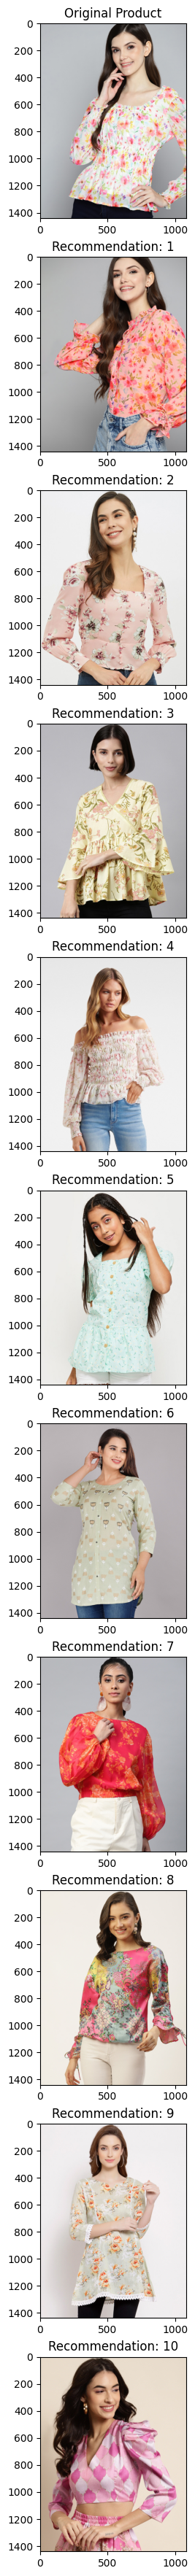

In [16]:
find_n_similar(1001, 10)